In [59]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from __future__ import absolute_import, division, print_function, unicode_literals


In [60]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names =['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

In [61]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [62]:
# We had around 6 NA values in our data, and we are dropping NA values
dataset = dataset.dropna()

# 'Origin' column is categorical so creating one hot encoding
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

train_data = dataset.sample(frac=0.8, random_state=0)
test_data = dataset.drop(train_data.index)
train_labels = train_data.pop('MPG')
test_labels = test_data.pop('MPG')

/var/folders/w6/304l7tqs0f946cfnk4fb4vg80000gp/T/ipykernel_77042/1787486774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['USA'] = (origin == 1)*1.0
/var/folders/w6/304l7tqs0f946cfnk4fb4vg80000gp/T/ipykernel_77042/1787486774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Europe'] = (origin == 2)*1.0
/var/folders/w6/304l7tqs0f946cfnk4fb4vg80000gp/T/ipykernel_77042/1787486774.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [63]:
train_data = dataset.sample(frac=0.8, random_state=0)
test_data = dataset.drop(train_data.index)
train_labels = train_data.pop('MPG')
test_labels = test_data.pop('MPG')

def normalization(x):
    train_stats = train_data.describe()
    train_stats = train_stats.transpose()
    return (x - train_stats['mean']) / train_stats['std']
      
normed_train_data = normalization(train_data)
normed_test_data = normalization(test_data)


In [64]:
def model_building():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_data.keys())]),layers.Dense(64, activation=tf.nn.relu), layers.Dense(1)])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=[
        'mean_absolute_error', 'mean_squared_error'])
    
    return model

model = model_building()

/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

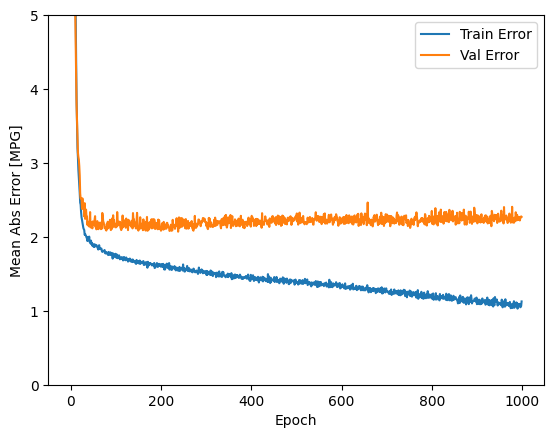

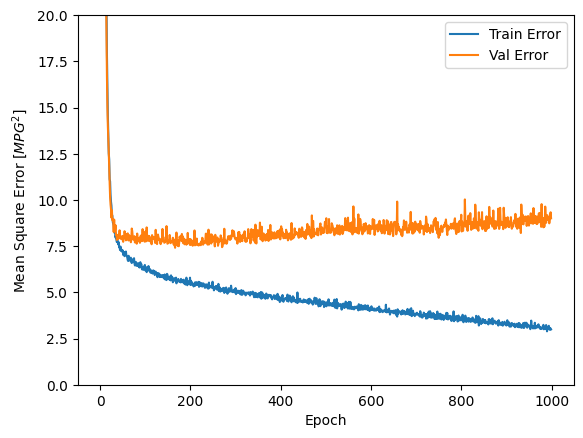

In [67]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_training_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
plot_training_history(history)

/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



.............................................................................

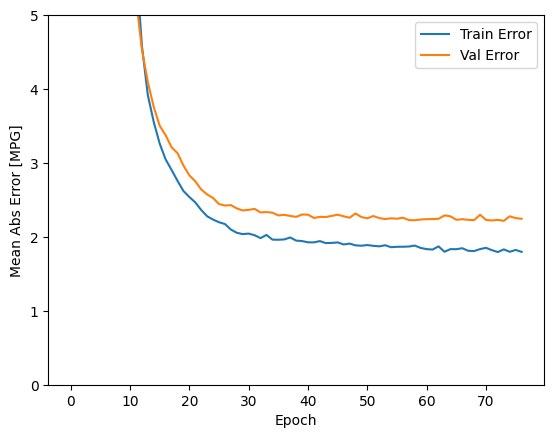

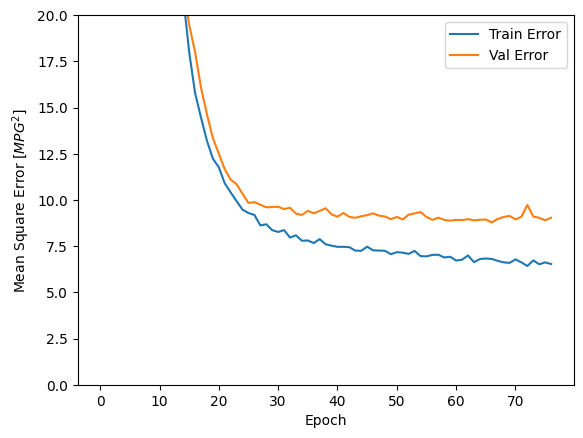

In [68]:
model = model_building()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_training_history(history)

In [69]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing dataset Mean Abs Error(MAE): {:5.2f} MPG".format(mae))

Testing dataset Mean Abs Error(MAE):  1.87 MPG


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


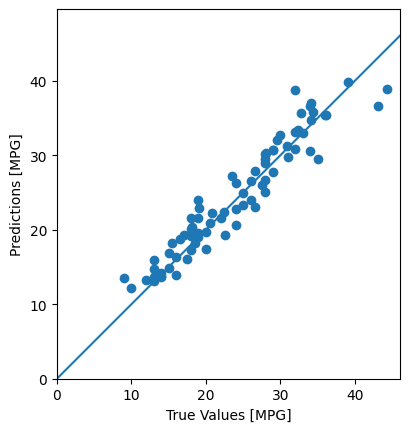

In [70]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

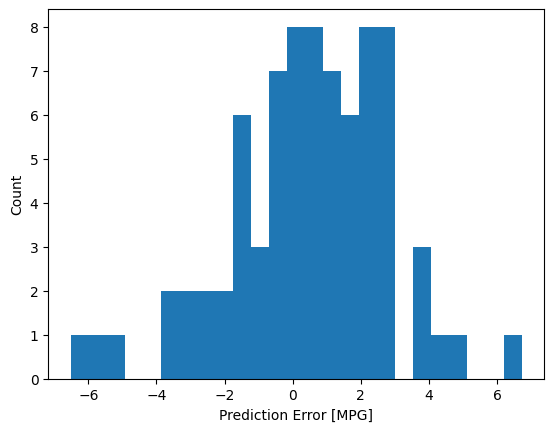

In [71]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()

In [72]:
model.save('myfirstmodel.h5')

from keras.models import load_model
newmodel = tf.keras.models.load_model('myfirstmodel.h5')

test_predictions = model.predict(normed_test_data).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
